## Math 156 Final Project Code
Group: Chinmay, Steve, Kanzah, William 

In [26]:
# Standard imports
import os
import cv2
import math
import numpy as np
import pandas as pd
import numpy.linalg as la
import numpy.random as npr
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNetCV, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# Statsmodels imports
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Ensure inline plotting for Jupyter notebooks
%matplotlib inline

### Data Cleaning

In [27]:
df = pd.read_csv('nba2.csv')
df['Season'] = df['Season'].apply(lambda x: int(x.split('-')[0])) # make the season column an int
# df = df[df['Season'] >= 2015] # filter seasons after a certain year
df.head()

,Rk,Season,Team,G,W,L,W/L%,MP,FG,FGA,...,O_FTA,O_ORB,O_DRB,O_TRB,O_AST,O_STL,O_BLK,O_TOV,O_PF,O_PTS
0,1,2023,ATL,82,36,46,0.439,242.1,43.0,92.5,...,21.8,10.6,33.6,44.2,28.2,7.8,5.6,14.1,19.4,120.5
1,2,2023,BOS,82,64,18,0.780,241.8,43.9,90.2,...,17.3,11.1,32.3,43.3,24.9,6.2,3.7,12.0,17.3,109.2
2,3,2023,CHO,82,21,61,0.256,240.6,40.0,87.0,...,20.7,10.6,34.8,45.4,28.7,7.1,4.8,13.6,17.5,116.8
3,4,2023,CHI,82,39,43,0.476,243.7,42.0,89.5,...,21.8,10.1,33.3,43.4,27.9,6.8,4.9,14.0,18.8,113.7
4,5,2023,CLE,82,48,34,0.585,241.5,41.8,87.2,...,21.0,10.0,32.6,42.7,25.3,7.7,5.0,13.6,18.7,110.2


Brief Data Exploration wrt 3 pointers

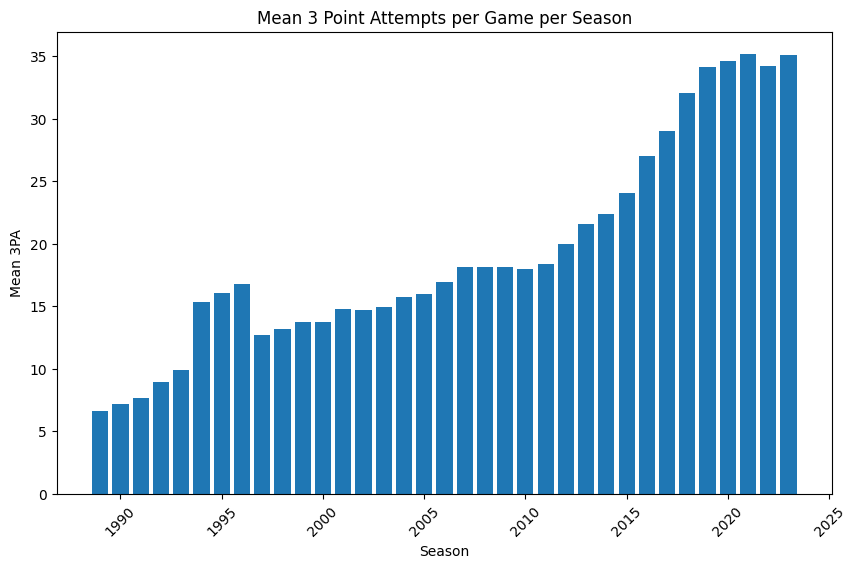

In [28]:
# Group by Season and calculate the mean of 3PA
mean_3pa = df.groupby('Season')['3PA'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(mean_3pa['Season'], mean_3pa['3PA'])
plt.xlabel('Season')
plt.ylabel('Mean 3PA')
plt.title('Mean 3 Point Attempts per Game per Season')
plt.xticks(rotation=45)
plt.show()

Data Cleaning Cont.

In [29]:
# Remove columns that are not the X or y
df = df.iloc[:, 6:] 

df.head()

,W/L%,MP,FG,FGA,2P,2PA,3P,3PA,FT,FTA,...,O_FTA,O_ORB,O_DRB,O_TRB,O_AST,O_STL,O_BLK,O_TOV,O_PF,O_PTS
0,0.439,242.1,43.0,92.5,29.3,54.8,13.7,37.7,18.5,23.2,...,21.8,10.6,33.6,44.2,28.2,7.8,5.6,14.1,19.4,120.5
1,0.780,241.8,43.9,90.2,27.4,47.7,16.5,42.5,16.3,20.2,...,17.3,11.1,32.3,43.3,24.9,6.2,3.7,12.0,17.3,109.2
2,0.256,240.6,40.0,87.0,28.0,53.0,12.1,34.0,14.5,18.4,...,20.7,10.6,34.8,45.4,28.7,7.1,4.8,13.6,17.5,116.8
3,0.476,243.7,42.0,89.5,30.6,57.4,11.5,32.1,16.7,21.1,...,21.8,10.1,33.3,43.4,27.9,6.8,4.9,14.0,18.8,113.7
4,0.585,241.5,41.8,87.2,28.3,50.4,13.5,36.8,15.6,20.4,...,21.0,10.0,32.6,42.7,25.3,7.7,5.0,13.6,18.7,110.2


### Data Pre-Processing

In [30]:
# Impute NAs in the data
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
num_imputer = SimpleImputer(strategy='mean')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

df.head()

,W/L%,MP,FG,FGA,2P,2PA,3P,3PA,FT,FTA,...,O_FTA,O_ORB,O_DRB,O_TRB,O_AST,O_STL,O_BLK,O_TOV,O_PF,O_PTS
0,0.439,242.1,43.0,92.5,29.3,54.8,13.7,37.7,18.5,23.2,...,21.8,10.6,33.6,44.2,28.2,7.8,5.6,14.1,19.4,120.5
1,0.780,241.8,43.9,90.2,27.4,47.7,16.5,42.5,16.3,20.2,...,17.3,11.1,32.3,43.3,24.9,6.2,3.7,12.0,17.3,109.2
2,0.256,240.6,40.0,87.0,28.0,53.0,12.1,34.0,14.5,18.4,...,20.7,10.6,34.8,45.4,28.7,7.1,4.8,13.6,17.5,116.8
3,0.476,243.7,42.0,89.5,30.6,57.4,11.5,32.1,16.7,21.1,...,21.8,10.1,33.3,43.4,27.9,6.8,4.9,14.0,18.8,113.7
4,0.585,241.5,41.8,87.2,28.3,50.4,13.5,36.8,15.6,20.4,...,21.0,10.0,32.6,42.7,25.3,7.7,5.0,13.6,18.7,110.2


Splitting Data

In [31]:
# the per game stats
X = df.iloc[:, 1:]
X.shape

(1023, 35)

In [32]:
# win percent in a season
y = df.iloc[:, 0]
y.shape

(1023,)

In [33]:
# Test, Train, Val split

# The 2023-24 season is the test data
X_test = X.iloc[:30]
y_test = y.iloc[:30]

# Remaining data for training and validation
X_remaining = X.iloc[30:]
y_remaining = y.iloc[30:]

X_train, X_val, y_train, y_val = train_test_split(X_remaining, y_remaining, random_state=42)

# Check the shapes
print(X_test.shape, y_test.shape)
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(30, 35) (30,)
(744, 35) (249, 35)
(744,) (249,)


Standardizing and Centering Data

In [34]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

### Dimensionality Redution and Handling Collinearity

In [35]:
# Do SVD on the data
U,S,VT = np.linalg.svd(X_train, full_matrices=False)

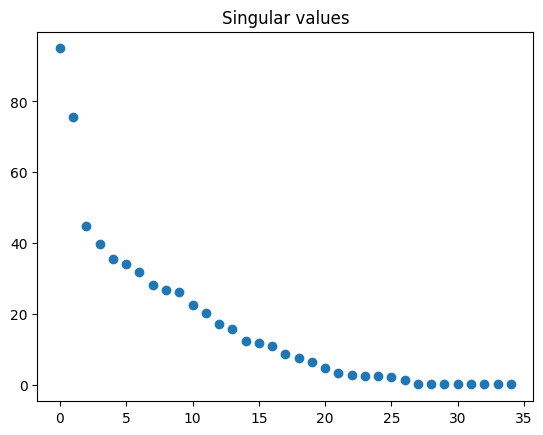

In [36]:
# Graph the singular values to determine the number of principle components to use for the analysis

plt.plot(S,'o')
plt.title('Singular values')
plt.show()

PCA

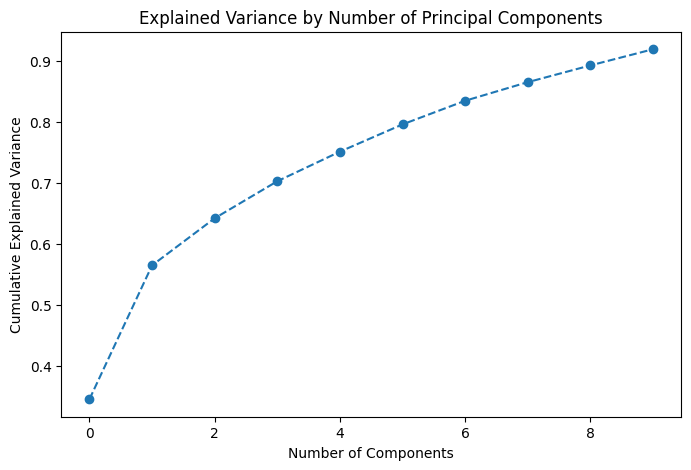

In [37]:
# PCA
pca = PCA(n_components=10)  # Using the 10 highest singular values
X_train_pca = pca.fit_transform(X_train)

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Principal Components')
plt.show()

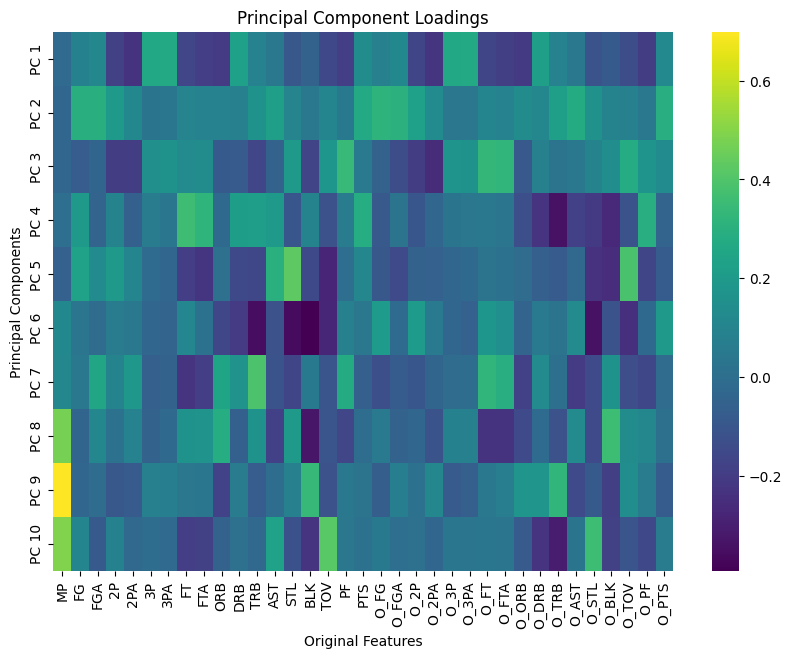

In [38]:
# Looking at the components from PCA

pca_weights = pca.components_

# Plotting the weights using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(pca_weights, cmap='viridis', annot=False, cbar=True,
            xticklabels=X.columns,
            yticklabels=[f'PC {i+1}' for i in range(pca.n_components_)])
plt.xlabel('Original Features')
plt.ylabel('Principal Components')
plt.title('Principal Component Loadings')
plt.xticks(rotation=90)  # Rotate x labels for better readability
plt.show()

In [39]:
# Transform the val data using the same steps
X_val = scaler.transform(X_val)  # Standardize
X_val_pca = pca.transform(X_val)  # Apply PCA

### Model Training and Comparison

Model Performance Comparison:
                            Model       MSE  R-squared  Adjusted R-squared
0               Linear Regression  0.004048   0.826321            0.819024
1                Ridge Regression  0.004047   0.826358            0.819063
2                Lasso Regression  0.023335  -0.001249           -0.043318
3                     Elastic Net  0.023335  -0.001249           -0.043318
4        Decision Tree Regression  0.013833   0.406476            0.381538
5        Random Forest Regression  0.005640   0.757987            0.747818
6    Gradient Boosting Regression  0.005020   0.784620            0.775570
7       Support Vector Regression  0.004943   0.787913            0.779002
8  K-Nearest Neighbors Regression  0.007049   0.697563            0.684856


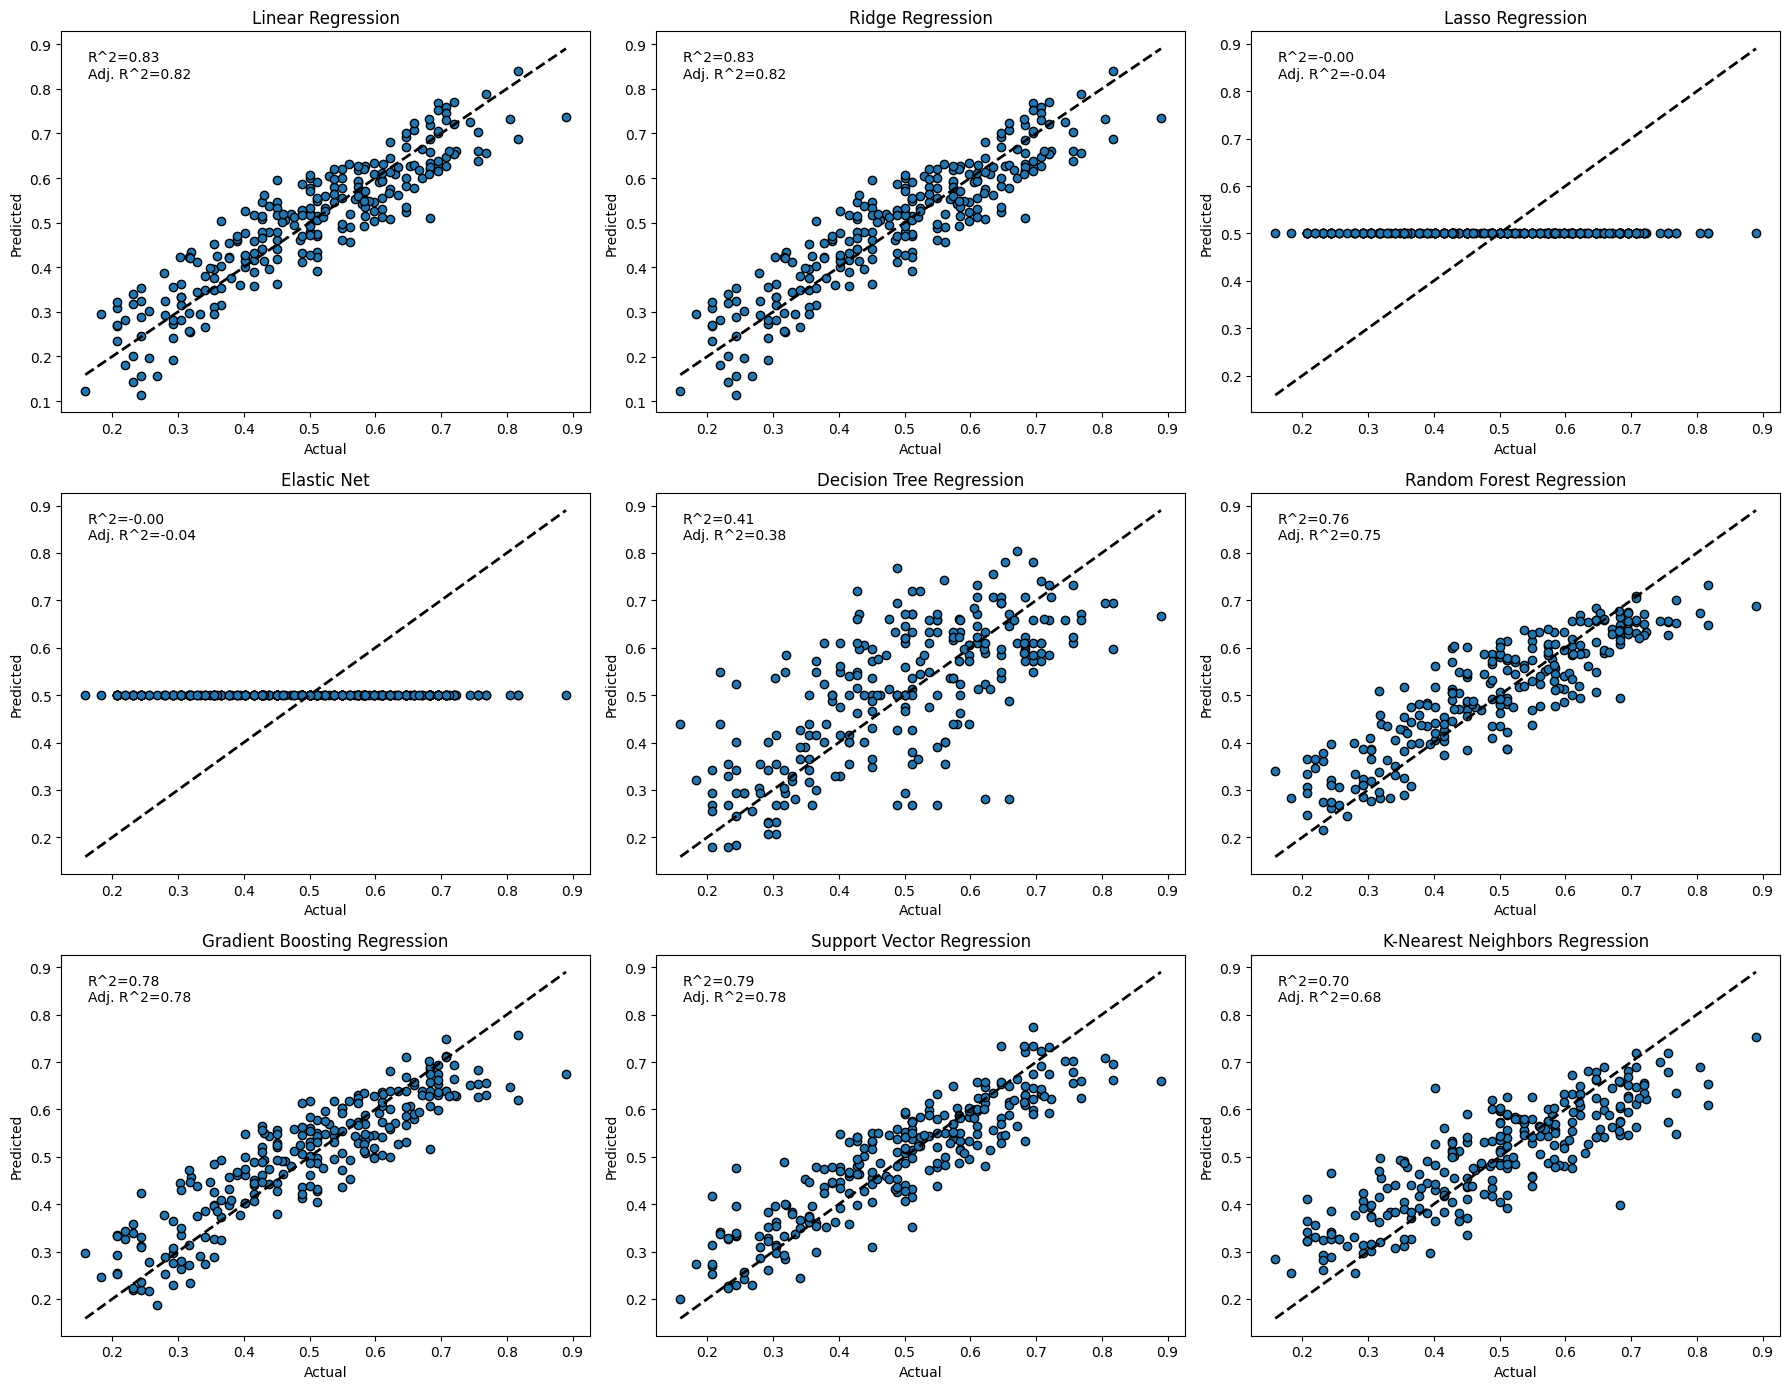

In [40]:
# Models initialization
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Elastic Net': ElasticNet(random_state=42),
    'Decision Tree Regression': DecisionTreeRegressor(random_state=42),
    'Random Forest Regression': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regression': GradientBoostingRegressor(random_state=42),
    'Support Vector Regression': SVR(),
    'K-Nearest Neighbors Regression': KNeighborsRegressor()
}

# Dictionaries to store results
mse_results = {}
r2_results = {}
adj_r2_results = {}

# Training and prediction
n = X_val_pca.shape[0]
p = X_val_pca.shape[1]
for name, model in models.items():
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_val_pca)
    mse_results[name] = mean_squared_error(y_val, y_pred)
    r2_results[name] = r2_score(y_val, y_pred)
    adj_r2_results[name] = 1 - (1 - r2_results[name]) * (n - 1) / (n - p - 1)

# Display results
results = pd.DataFrame({
    'Model': list(mse_results.keys()),
    'MSE': list(mse_results.values()),
    'R-squared': list(r2_results.values()),
    'Adjusted R-squared': list(adj_r2_results.values())
})

print("Model Performance Comparison:")
print(results)

# Plotting actual vs predicted values for each model
plt.figure(figsize=(18, 14))

# Iterate over models for plotting
for i, (name, model) in enumerate(models.items(), 1):
    plt.subplot(3, 3, i)
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_val_pca)
    plt.scatter(y_val, y_pred, edgecolors=(0, 0, 0))
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(name)
    plt.text(0.05, 0.95, f'R^2={r2_results[name]:.2f}\nAdj. R^2={adj_r2_results[name]:.2f}',
             transform=plt.gca().transAxes,
             verticalalignment='top')

plt.tight_layout()
plt.show()

\begin{equation}
\text{Adjusted } R^2 = 1 - \left(1 - R^2\right) \frac{n - 1}{n - p - 1}
\end{equation}

n is the number of observations and p is the number of predictors

### Hyperparameter Optimization:

Elastic Net

In [41]:
# Define the parameter grid
# en_params = {
#     'alpha': np.logspace(-5, 1, 50),
#     'l1_ratio': np.logspace(-5, 1, 50),
# }

# en = GridSearchCV(ElasticNet(random_state=42), en_params, cv=5, n_jobs=-1, verbose=True)
# en.fit(X_train_pca, y_train)
# print(f"ElasticNet Best Parameters: {en.best_params_}")
# y_en = en.predict(X_val_pca)
# mse_en = mean_squared_error(y_val, y_en)
# r2_en = r2_score(y_val, y_en)
# print(f"MSE: {mse_en}")
# print(f"R^2 Score: {r2_en}")

Random Forrest Regressor

In [42]:
# Define the parameter grid
# rfr_params = {
#     "criterion": ["squared_error", "friedman_mse"],
#     "min_samples_split": [2, 3, 4],
#     "min_samples_leaf": [1, 2, 3],
#     "min_weight_fraction_leaf": [0, 0.005, 0.01, 0.02],
#     "max_features": [1.0, 3, 5, "log2"]
# }

# rfr = GridSearchCV(RandomForestRegressor(n_estimators=250, random_state=42), rfr_params, cv=5, n_jobs=-1, verbose=True)
# rfr.fit(X_train_pca, y_train)
# print(f"RFR Best Parameters: {rfr.best_params_}")
# y_rfr = rfr.predict(X_val_pca)
# mse_rfr = mean_squared_error(y_rfr, y_val)
# r2_rfr = r2_score(y_rfr, y_val)
# print(mse_rfr)
# print(r2_rfr)

Decision Tree Regressor

In [43]:
# Define the parameter grid
# dec_params = rfr_params

# dec = GridSearchCV(DecisionTreeRegressor(random_state=42), dec_params, cv=20, n_jobs=-1, verbose=True)
# dec.fit(X_train_pca, y_train)
# print(f"Decision Tree Best Parameters: {dec.best_params_}")
# y_dec = dec.predict(X_val_pca)
# mse_dec = mean_squared_error(y_dec, y_val)
# r2_dec = r2_score(y_dec, y_val)
# print(mse_dec)
# print(r2_dec)

Gradient Boost

In [44]:
# Define the parameter grid
# gb_params = {
#     "loss": ["squared_error"],
#     "learning_rate": [0.01, 0.1, 1],
#     "subsample": [(i+1)/5 for i in list(range(5))],
#     "criterion": ["squared_error", "friedman_mse"],
#     "min_samples_split": [2, 3, 4, 5],
#     "min_samples_leaf": [1, 2, 3],
#     "min_weight_fraction_leaf": [0, 0.005, 0.01],
#     "max_features": [1.0, 3, 5, "log2"]
# }

# gb = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_params, cv=5, n_jobs=-1, verbose=True)
# gb.fit(X_train_pca, y_train)
# print(f"Gradient Boost Best Parameters: {gb.best_params_}")
# y_gb = gb.predict(X_val_pca)
# mse_gb = mean_squared_error(y_gb, y_val)
# r2_gb = r2_score(y_gb, y_val)
# print(mse_gb)
# print(r2_gb)

SVR

In [45]:
# Define the parameter grid
# svr_params = {
#     "kernel": ["poly", "rbf", "sigmoid"],
#     "degree": [3, 4, 5],
#     "gamma": ["scale", "auto"],
#     "tol": [1e-6],
#     "C": [0.1, 1, 10],
#     "epsilon": [0.01, 0.1, 0.5]
# }

# svr = GridSearchCV(SVR(), svr_params, cv=5, n_jobs=-1, verbose=True)
# svr.fit(X_train_pca, y_train)
# print(f"SVR Best Parameters: {svr.best_params_}")
# y_svr = svr.predict(X_val_pca)
# mse_svr = mean_squared_error(y_svr, y_val)
# r2_svr = r2_score(y_svr, y_val)
# print(mse_svr)
# print(r2_svr)

KNN

In [46]:
# Define the parameter grid
# knr_params = {
#     "n_neighbors": [x + 1 for x in range(15)],
#     "weights": ["uniform", "distance"],
#     "algorithm": ["ball_tree", "kd_tree", "brute", "auto"],
#     "p": [1, 2, 3, 4, 5, 6],
#     "metric": ["minkowski"],
# }

# knr = GridSearchCV(KNeighborsRegressor(leaf_size=20), knr_params, cv=20, n_jobs=-1, verbose=True)
# knr.fit(X_train_pca, y_train)
# print(f"knr Best Parameters: {knr.best_params_}")
# y_knr = knr.predict(X_val_pca)
# mse_knr = mean_squared_error(y_knr, y_val)
# r2_knr = r2_score(y_knr, y_val)
# print(mse_knr)
# print(r2_knr)

### Optimized Model Evaluation

Model Performance Comparison:
                            Model       MSE  R-squared  Adjusted R-squared
0                     Elastic Net  0.004035   0.826885            0.819612
1        Decision Tree Regression  0.010675   0.541942            0.522696
2        Random Forest Regression  0.005640   0.757987            0.747818
3    Gradient Boosting Regression  0.004883   0.790500            0.781698
4       Support Vector Regression  0.004084   0.824760            0.817397
5  K-Nearest Neighbors Regression  0.006516   0.720410            0.708662


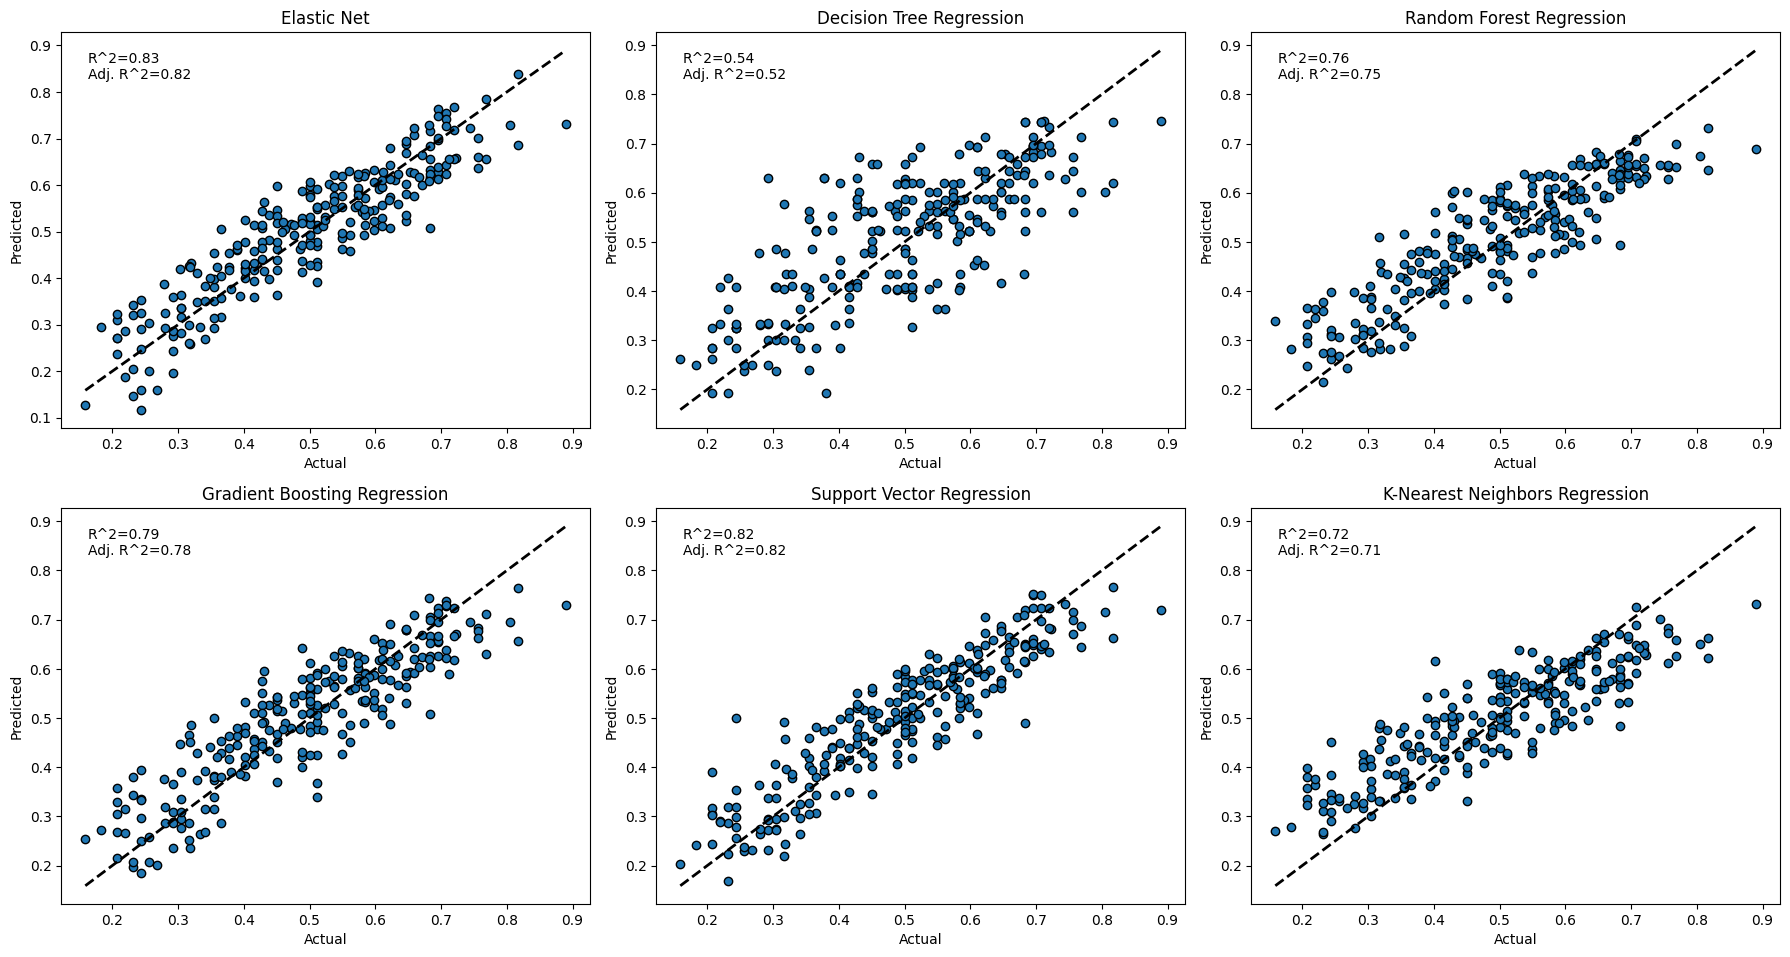

In [47]:
# Models initialization with optimized parameters
models = {
    'Elastic Net': ElasticNet(alpha=0.0008765584072672502, l1_ratio=0.99999, max_iter= 1000, tol= 0.001, random_state=42),
    'Decision Tree Regression': DecisionTreeRegressor(criterion='squared_error', max_features=5, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.01, random_state=42),
    'Random Forest Regression': RandomForestRegressor(criterion='squared_error', max_features=1.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0, random_state=42),
    'Gradient Boosting Regression': GradientBoostingRegressor(criterion='friedman_mse', learning_rate=0.1, loss='squared_error', max_features=1.0, min_samples_leaf=1, min_samples_split=5, min_weight_fraction_leaf=0, subsample=0.6, random_state=42),
    'Support Vector Regression': SVR(C=0.1, degree=3, epsilon=0.01, gamma='scale', kernel='rbf', tol=1e-06),
    'K-Nearest Neighbors Regression': KNeighborsRegressor(algorithm='ball_tree', metric='minkowski', n_neighbors=7, p=3, weights='distance')
}

# Dictionaries to store results
mse_results = {}
r2_results = {}
adj_r2_results = {}

# Training and prediction
n = X_val_pca.shape[0]
p = X_val_pca.shape[1]
for name, model in models.items():
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_val_pca)
    mse_results[name] = mean_squared_error(y_val, y_pred)
    r2_results[name] = r2_score(y_val, y_pred)
    adj_r2_results[name] = 1 - (1 - r2_results[name]) * (n - 1) / (n - p - 1)

# Display results
results = pd.DataFrame({
    'Model': list(mse_results.keys()),
    'MSE': list(mse_results.values()),
    'R-squared': list(r2_results.values()),
    'Adjusted R-squared': list(adj_r2_results.values())
})

print("Model Performance Comparison:")
print(results)

# Plotting actual vs predicted values for each model
plt.figure(figsize=(18, 14))

# Iterate over models for plotting
for i, (name, model) in enumerate(models.items(), 1):
    plt.subplot(3, 3, i)
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_val_pca)
    plt.scatter(y_val, y_pred, edgecolors=(0, 0, 0))
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(name)
    plt.text(0.05, 0.95, f'R^2={r2_results[name]:.2f}\nAdj. R^2={adj_r2_results[name]:.2f}',
             transform=plt.gca().transAxes,
             verticalalignment='top')

plt.tight_layout()
plt.show()

### Test Set
Prediction the 2023-2024 season

In [48]:
# Transform the test data using the same steps
X_test = scaler.transform(X_test)  # Standardize
X_test_pca = pca.transform(X_test)  # Apply PCA

LASSO

Elastic Net Model Performance on Test Set:
               Metric     Value
0                 MSE  0.002854
1           R-squared  0.889635
2  Adjusted R-squared  0.831548


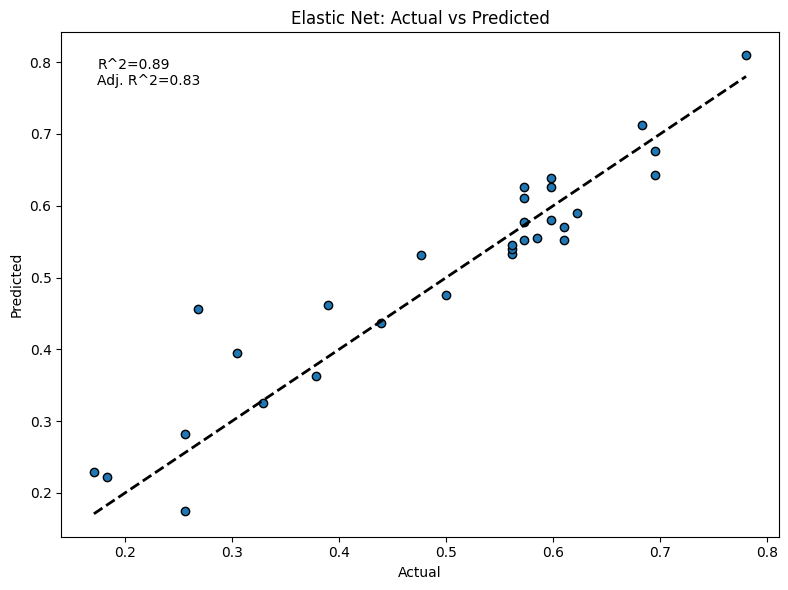

In [49]:
# Use the trained and optimized Elastic Net model
elastic_net_model = models['Elastic Net']
y_test_pred = elastic_net_model.predict(X_test_pca)

# Evaluate the performance on the test set
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
n_test = X_test_pca.shape[0]
p_test = X_test_pca.shape[1]
adj_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p_test - 1)

# Display test results
test_results = pd.DataFrame({
    'Metric': ['MSE', 'R-squared', 'Adjusted R-squared'],
    'Value': [mse_test, r2_test, adj_r2_test]
})

print("Elastic Net Model Performance on Test Set:")
print(test_results)

# Plotting actual vs predicted values for the test set
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, edgecolors=(0, 0, 0))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Elastic Net: Actual vs Predicted')
plt.text(0.05, 0.95, f'R^2={r2_test:.2f}\nAdj. R^2={adj_r2_test:.2f}',
         transform=plt.gca().transAxes,
         verticalalignment='top')
plt.tight_layout()
plt.show()


Gradient Boosting

Gradient Boosting Model Performance on Test Set:
               Metric     Value
0                 MSE  0.002573
1           R-squared  0.900487
2  Adjusted R-squared  0.848111


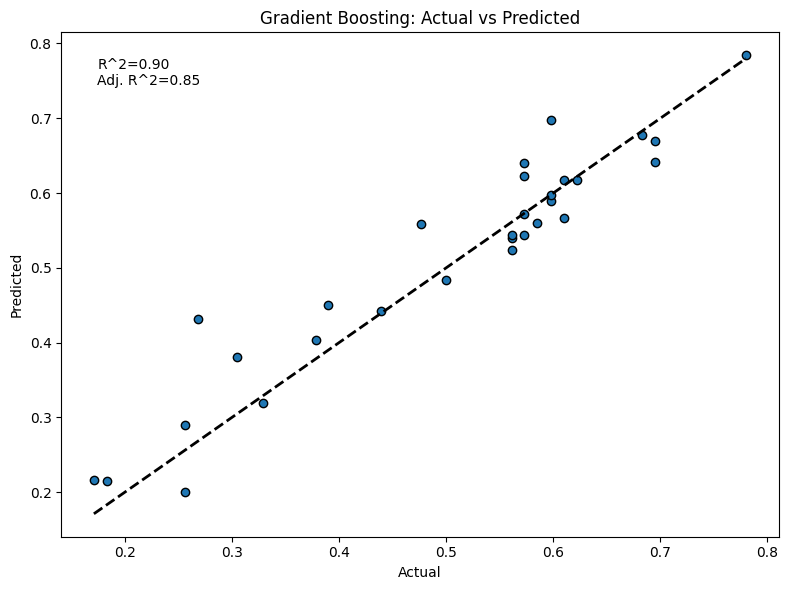

In [50]:
# Use the trained and optimized Gradient Boosting model
gradient_boosting_model = models['Gradient Boosting Regression']
y_test_pred = gradient_boosting_model.predict(X_test_pca)

# Evaluate the performance on the test set
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
n_test = X_test_pca.shape[0]
p_test = X_test_pca.shape[1]
adj_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p_test - 1)

# Display test results
test_results = pd.DataFrame({
    'Metric': ['MSE', 'R-squared', 'Adjusted R-squared'],
    'Value': [mse_test, r2_test, adj_r2_test]
})

print("Gradient Boosting Model Performance on Test Set:")
print(test_results)

# Plotting actual vs predicted values for the test set
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, edgecolors=(0, 0, 0))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Gradient Boosting: Actual vs Predicted')
plt.text(0.05, 0.95, f'R^2={r2_test:.2f}\nAdj. R^2={adj_r2_test:.2f}',
         transform=plt.gca().transAxes,
         verticalalignment='top')
plt.tight_layout()
plt.show()